In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import pulp
from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpContinuous, lpSum, lpDot, value
from ortoolpy import model_min, addvars, addvals

# Variable setting function

In [2]:
def set_variable_growth(data, variable, rate_min, rate_max):
    """
    Set variables with uncertainty ranges based on growth rate and linear interpolation
    """
    # Get the data for the year 2021
    data_2021 = data.at[121, variable]

    # Get the data for the year 2050
    data_2050 = np.random.uniform(data_2021 * rate_min, data_2021 * rate_max)

    # Calculate the slope to linearly interpolate data for the year 2050
    slope = (data_2050 - data_2021) / (150 -121)

    # Linearly interpolate data from the year 2021 to 2050
    for i in range(121, 151):
        data.at[i, variable] = data_2021 + slope * (i - 121)
        
    return data[variable]

def set_variable_target(data, variable, target_min, target_max):
    """
    Set variables with uncertainty ranges based on specific target values and linear interpolation
    """
    # Get the data for the year 2021
    data_2021 = data.at[121, variable]

    # Get the data for the year 2050
    data_2050 = np.random.uniform(target_min, target_max)

    # Calculate the slope to linearly interpolate data for the year 2050
    slope = (data_2050 - data_2021) / (150 -121)

    # Linearly interpolate data from the year 2021 to 2050
    for i in range(121, 151):
        data.at[i, variable] = data_2021 + slope * (i - 121)
        
    return data[variable]

def set_variable_zero(data, variable, target_year_min, target_year_max):
    """
    Set variables with uncertainty ranges based on linear interpolation to reach zero by a target year
    """
    # Get the data for the year 2021
    data_2021 = data.at[121, variable]
    
    # Randomly select the target year from a uniform distribution
    target_year = np.random.randint(target_year_min, target_year_max)
    
    # Calculate the slope to linearly interpolate data to reach zero by the target year
    slope = - data_2021 / (target_year - 121)
    
    # Linearly interpolate data from the year 2021 to the target year
    for i in range(121, target_year + 1):
        data.at[i, variable] = data_2021 + slope * (i - 121)
    
    # Set data from target year to 2050 to 0
    for i in range(target_year, 151):
        data.at[i, variable] = 0
        
    return data[variable]

# "Forecasting supply and backcasting demand" model

In [4]:
# Read the datafile
with pd.ExcelFile(r'data_cement.xlsx') as xls:
    data = pd.read_excel(xls, sheet_name='data', skiprows=1)

# Create empty dataframes for results
pro_mcs = pd.DataFrame()

# Perform iterations of the optimisation
for n in range(5000):
    
    #Set constraints with uncertainty ranges
    electricity_max = set_variable_growth(data, 'electricity_max', 1.41, 2.51)
    ccs_max = set_variable_target(data, 'ccs_max', 18, 1355)
    EI_electricity = set_variable_zero(data, 'EI_electricity', 140, 150)
    
    # Add optimisation variables
    data['Var_pro'] = addvars(len(data))
    
    # Calculate clinker production
    clinker = data['Var_pro'] * data.clinker_ratio
    
    # Calculate electricity requirements
    electricity_req = (data['Var_pro'] + ccs_max) * data.electric_energy
    
    # Calculate emissions
    emissions = ((clinker * data.process_emission) + (clinker * data.thermal_energy * data.EI_thermal) + (electricity_req * data.EI_electricity))/1000
    
    # Define objective function
    model = LpProblem(sense = LpMaximize)
    model += lpSum([data['Var_pro'][t] for t in data.index])
    
    for t in data.index:
        
        # Carbon budget
        model += (emissions[t] - ccs_max[t]) <= data.carbon_budget[t]
    
        # Maximum electricity supply
        model += electricity_req[t] <= electricity_max[t]
    
        # Non-negative constraints
        model += data['Var_pro'][t] >=0

    # Solve the model
    model.solve(solver=pulp.PULP_CBC_CMD(msg=False))
    
    data['Val_pro'] = data['Var_pro'].apply(value)
    
    pro_mcs = pd.concat([pro_mcs, data['Val_pro']], axis=1)
    
    print("Number of iterations = {}".format(n))

# Calculate percentiles
def calculate_percentiles(data, percentiles):
    return data.quantile(percentiles, axis=1).T

percentiles = [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98]
pro_percentiles = calculate_percentiles(pro_mcs, percentiles)

# Write data to excel
pro_percentiles.index = data.year
pro_mcs.index = data.year

with pd.ExcelWriter('outputs'+'/cement.xlsx') as writer:
    pro_percentiles.to_excel(writer, sheet_name = 'production')
    pro_mcs.to_excel(writer, sheet_name = 'distribution')

Number of iterations = 0
Number of iterations = 1
Number of iterations = 2
Number of iterations = 3
Number of iterations = 4
Number of iterations = 5
Number of iterations = 6
Number of iterations = 7
Number of iterations = 8
Number of iterations = 9
Number of iterations = 10
Number of iterations = 11
Number of iterations = 12
Number of iterations = 13
Number of iterations = 14
Number of iterations = 15
Number of iterations = 16
Number of iterations = 17
Number of iterations = 18
Number of iterations = 19
Number of iterations = 20
Number of iterations = 21
Number of iterations = 22
Number of iterations = 23
Number of iterations = 24
Number of iterations = 25
Number of iterations = 26
Number of iterations = 27
Number of iterations = 28
Number of iterations = 29
Number of iterations = 30
Number of iterations = 31
Number of iterations = 32
Number of iterations = 33
Number of iterations = 34
Number of iterations = 35
Number of iterations = 36
Number of iterations = 37
Number of iterations =

Number of iterations = 312
Number of iterations = 313
Number of iterations = 314
Number of iterations = 315
Number of iterations = 316
Number of iterations = 317
Number of iterations = 318
Number of iterations = 319
Number of iterations = 320
Number of iterations = 321
Number of iterations = 322
Number of iterations = 323
Number of iterations = 324
Number of iterations = 325
Number of iterations = 326
Number of iterations = 327
Number of iterations = 328
Number of iterations = 329
Number of iterations = 330
Number of iterations = 331
Number of iterations = 332
Number of iterations = 333
Number of iterations = 334
Number of iterations = 335
Number of iterations = 336
Number of iterations = 337
Number of iterations = 338
Number of iterations = 339
Number of iterations = 340
Number of iterations = 341
Number of iterations = 342
Number of iterations = 343
Number of iterations = 344
Number of iterations = 345
Number of iterations = 346
Number of iterations = 347
Number of iterations = 348
N

Number of iterations = 618
Number of iterations = 619
Number of iterations = 620
Number of iterations = 621
Number of iterations = 622
Number of iterations = 623
Number of iterations = 624
Number of iterations = 625
Number of iterations = 626
Number of iterations = 627
Number of iterations = 628
Number of iterations = 629
Number of iterations = 630
Number of iterations = 631
Number of iterations = 632
Number of iterations = 633
Number of iterations = 634
Number of iterations = 635
Number of iterations = 636
Number of iterations = 637
Number of iterations = 638
Number of iterations = 639
Number of iterations = 640
Number of iterations = 641
Number of iterations = 642
Number of iterations = 643
Number of iterations = 644
Number of iterations = 645
Number of iterations = 646
Number of iterations = 647
Number of iterations = 648
Number of iterations = 649
Number of iterations = 650
Number of iterations = 651
Number of iterations = 652
Number of iterations = 653
Number of iterations = 654
N

Number of iterations = 925
Number of iterations = 926
Number of iterations = 927
Number of iterations = 928
Number of iterations = 929
Number of iterations = 930
Number of iterations = 931
Number of iterations = 932
Number of iterations = 933
Number of iterations = 934
Number of iterations = 935
Number of iterations = 936
Number of iterations = 937
Number of iterations = 938
Number of iterations = 939
Number of iterations = 940
Number of iterations = 941
Number of iterations = 942
Number of iterations = 943
Number of iterations = 944
Number of iterations = 945
Number of iterations = 946
Number of iterations = 947
Number of iterations = 948
Number of iterations = 949
Number of iterations = 950
Number of iterations = 951
Number of iterations = 952
Number of iterations = 953
Number of iterations = 954
Number of iterations = 955
Number of iterations = 956
Number of iterations = 957
Number of iterations = 958
Number of iterations = 959
Number of iterations = 960
Number of iterations = 961
N

Number of iterations = 1224
Number of iterations = 1225
Number of iterations = 1226
Number of iterations = 1227
Number of iterations = 1228
Number of iterations = 1229
Number of iterations = 1230
Number of iterations = 1231
Number of iterations = 1232
Number of iterations = 1233
Number of iterations = 1234
Number of iterations = 1235
Number of iterations = 1236
Number of iterations = 1237
Number of iterations = 1238
Number of iterations = 1239
Number of iterations = 1240
Number of iterations = 1241
Number of iterations = 1242
Number of iterations = 1243
Number of iterations = 1244
Number of iterations = 1245
Number of iterations = 1246
Number of iterations = 1247
Number of iterations = 1248
Number of iterations = 1249
Number of iterations = 1250
Number of iterations = 1251
Number of iterations = 1252
Number of iterations = 1253
Number of iterations = 1254
Number of iterations = 1255
Number of iterations = 1256
Number of iterations = 1257
Number of iterations = 1258
Number of iterations

Number of iterations = 1517
Number of iterations = 1518
Number of iterations = 1519
Number of iterations = 1520
Number of iterations = 1521
Number of iterations = 1522
Number of iterations = 1523
Number of iterations = 1524
Number of iterations = 1525
Number of iterations = 1526
Number of iterations = 1527
Number of iterations = 1528
Number of iterations = 1529
Number of iterations = 1530
Number of iterations = 1531
Number of iterations = 1532
Number of iterations = 1533
Number of iterations = 1534
Number of iterations = 1535
Number of iterations = 1536
Number of iterations = 1537
Number of iterations = 1538
Number of iterations = 1539
Number of iterations = 1540
Number of iterations = 1541
Number of iterations = 1542
Number of iterations = 1543
Number of iterations = 1544
Number of iterations = 1545
Number of iterations = 1546
Number of iterations = 1547
Number of iterations = 1548
Number of iterations = 1549
Number of iterations = 1550
Number of iterations = 1551
Number of iterations

Number of iterations = 1814
Number of iterations = 1815
Number of iterations = 1816
Number of iterations = 1817
Number of iterations = 1818
Number of iterations = 1819
Number of iterations = 1820
Number of iterations = 1821
Number of iterations = 1822
Number of iterations = 1823
Number of iterations = 1824
Number of iterations = 1825
Number of iterations = 1826
Number of iterations = 1827
Number of iterations = 1828
Number of iterations = 1829
Number of iterations = 1830
Number of iterations = 1831
Number of iterations = 1832
Number of iterations = 1833
Number of iterations = 1834
Number of iterations = 1835
Number of iterations = 1836
Number of iterations = 1837
Number of iterations = 1838
Number of iterations = 1839
Number of iterations = 1840
Number of iterations = 1841
Number of iterations = 1842
Number of iterations = 1843
Number of iterations = 1844
Number of iterations = 1845
Number of iterations = 1846
Number of iterations = 1847
Number of iterations = 1848
Number of iterations

Number of iterations = 2110
Number of iterations = 2111
Number of iterations = 2112
Number of iterations = 2113
Number of iterations = 2114
Number of iterations = 2115
Number of iterations = 2116
Number of iterations = 2117
Number of iterations = 2118
Number of iterations = 2119
Number of iterations = 2120
Number of iterations = 2121
Number of iterations = 2122
Number of iterations = 2123
Number of iterations = 2124
Number of iterations = 2125
Number of iterations = 2126
Number of iterations = 2127
Number of iterations = 2128
Number of iterations = 2129
Number of iterations = 2130
Number of iterations = 2131
Number of iterations = 2132
Number of iterations = 2133
Number of iterations = 2134
Number of iterations = 2135
Number of iterations = 2136
Number of iterations = 2137
Number of iterations = 2138
Number of iterations = 2139
Number of iterations = 2140
Number of iterations = 2141
Number of iterations = 2142
Number of iterations = 2143
Number of iterations = 2144
Number of iterations

Number of iterations = 2405
Number of iterations = 2406
Number of iterations = 2407
Number of iterations = 2408
Number of iterations = 2409
Number of iterations = 2410
Number of iterations = 2411
Number of iterations = 2412
Number of iterations = 2413
Number of iterations = 2414
Number of iterations = 2415
Number of iterations = 2416
Number of iterations = 2417
Number of iterations = 2418
Number of iterations = 2419
Number of iterations = 2420
Number of iterations = 2421
Number of iterations = 2422
Number of iterations = 2423
Number of iterations = 2424
Number of iterations = 2425
Number of iterations = 2426
Number of iterations = 2427
Number of iterations = 2428
Number of iterations = 2429
Number of iterations = 2430
Number of iterations = 2431
Number of iterations = 2432
Number of iterations = 2433
Number of iterations = 2434
Number of iterations = 2435
Number of iterations = 2436
Number of iterations = 2437
Number of iterations = 2438
Number of iterations = 2439
Number of iterations

Number of iterations = 2698
Number of iterations = 2699
Number of iterations = 2700
Number of iterations = 2701
Number of iterations = 2702
Number of iterations = 2703
Number of iterations = 2704
Number of iterations = 2705
Number of iterations = 2706
Number of iterations = 2707
Number of iterations = 2708
Number of iterations = 2709
Number of iterations = 2710
Number of iterations = 2711
Number of iterations = 2712
Number of iterations = 2713
Number of iterations = 2714
Number of iterations = 2715
Number of iterations = 2716
Number of iterations = 2717
Number of iterations = 2718
Number of iterations = 2719
Number of iterations = 2720
Number of iterations = 2721
Number of iterations = 2722
Number of iterations = 2723
Number of iterations = 2724
Number of iterations = 2725
Number of iterations = 2726
Number of iterations = 2727
Number of iterations = 2728
Number of iterations = 2729
Number of iterations = 2730
Number of iterations = 2731
Number of iterations = 2732
Number of iterations

Number of iterations = 2994
Number of iterations = 2995
Number of iterations = 2996
Number of iterations = 2997
Number of iterations = 2998
Number of iterations = 2999
Number of iterations = 3000
Number of iterations = 3001
Number of iterations = 3002
Number of iterations = 3003
Number of iterations = 3004
Number of iterations = 3005
Number of iterations = 3006
Number of iterations = 3007
Number of iterations = 3008
Number of iterations = 3009
Number of iterations = 3010
Number of iterations = 3011
Number of iterations = 3012
Number of iterations = 3013
Number of iterations = 3014
Number of iterations = 3015
Number of iterations = 3016
Number of iterations = 3017
Number of iterations = 3018
Number of iterations = 3019
Number of iterations = 3020
Number of iterations = 3021
Number of iterations = 3022
Number of iterations = 3023
Number of iterations = 3024
Number of iterations = 3025
Number of iterations = 3026
Number of iterations = 3027
Number of iterations = 3028
Number of iterations

Number of iterations = 3288
Number of iterations = 3289
Number of iterations = 3290
Number of iterations = 3291
Number of iterations = 3292
Number of iterations = 3293
Number of iterations = 3294
Number of iterations = 3295
Number of iterations = 3296
Number of iterations = 3297
Number of iterations = 3298
Number of iterations = 3299
Number of iterations = 3300
Number of iterations = 3301
Number of iterations = 3302
Number of iterations = 3303
Number of iterations = 3304
Number of iterations = 3305
Number of iterations = 3306
Number of iterations = 3307
Number of iterations = 3308
Number of iterations = 3309
Number of iterations = 3310
Number of iterations = 3311
Number of iterations = 3312
Number of iterations = 3313
Number of iterations = 3314
Number of iterations = 3315
Number of iterations = 3316
Number of iterations = 3317
Number of iterations = 3318
Number of iterations = 3319
Number of iterations = 3320
Number of iterations = 3321
Number of iterations = 3322
Number of iterations

Number of iterations = 3581
Number of iterations = 3582
Number of iterations = 3583
Number of iterations = 3584
Number of iterations = 3585
Number of iterations = 3586
Number of iterations = 3587
Number of iterations = 3588
Number of iterations = 3589
Number of iterations = 3590
Number of iterations = 3591
Number of iterations = 3592
Number of iterations = 3593
Number of iterations = 3594
Number of iterations = 3595
Number of iterations = 3596
Number of iterations = 3597
Number of iterations = 3598
Number of iterations = 3599
Number of iterations = 3600
Number of iterations = 3601
Number of iterations = 3602
Number of iterations = 3603
Number of iterations = 3604
Number of iterations = 3605
Number of iterations = 3606
Number of iterations = 3607
Number of iterations = 3608
Number of iterations = 3609
Number of iterations = 3610
Number of iterations = 3611
Number of iterations = 3612
Number of iterations = 3613
Number of iterations = 3614
Number of iterations = 3615
Number of iterations

Number of iterations = 3874
Number of iterations = 3875
Number of iterations = 3876
Number of iterations = 3877
Number of iterations = 3878
Number of iterations = 3879
Number of iterations = 3880
Number of iterations = 3881
Number of iterations = 3882
Number of iterations = 3883
Number of iterations = 3884
Number of iterations = 3885
Number of iterations = 3886
Number of iterations = 3887
Number of iterations = 3888
Number of iterations = 3889
Number of iterations = 3890
Number of iterations = 3891
Number of iterations = 3892
Number of iterations = 3893
Number of iterations = 3894
Number of iterations = 3895
Number of iterations = 3896
Number of iterations = 3897
Number of iterations = 3898
Number of iterations = 3899
Number of iterations = 3900
Number of iterations = 3901
Number of iterations = 3902
Number of iterations = 3903
Number of iterations = 3904
Number of iterations = 3905
Number of iterations = 3906
Number of iterations = 3907
Number of iterations = 3908
Number of iterations

Number of iterations = 4167
Number of iterations = 4168
Number of iterations = 4169
Number of iterations = 4170
Number of iterations = 4171
Number of iterations = 4172
Number of iterations = 4173
Number of iterations = 4174
Number of iterations = 4175
Number of iterations = 4176
Number of iterations = 4177
Number of iterations = 4178
Number of iterations = 4179
Number of iterations = 4180
Number of iterations = 4181
Number of iterations = 4182
Number of iterations = 4183
Number of iterations = 4184
Number of iterations = 4185
Number of iterations = 4186
Number of iterations = 4187
Number of iterations = 4188
Number of iterations = 4189
Number of iterations = 4190
Number of iterations = 4191
Number of iterations = 4192
Number of iterations = 4193
Number of iterations = 4194
Number of iterations = 4195
Number of iterations = 4196
Number of iterations = 4197
Number of iterations = 4198
Number of iterations = 4199
Number of iterations = 4200
Number of iterations = 4201
Number of iterations

Number of iterations = 4461
Number of iterations = 4462
Number of iterations = 4463
Number of iterations = 4464
Number of iterations = 4465
Number of iterations = 4466
Number of iterations = 4467
Number of iterations = 4468
Number of iterations = 4469
Number of iterations = 4470
Number of iterations = 4471
Number of iterations = 4472
Number of iterations = 4473
Number of iterations = 4474
Number of iterations = 4475
Number of iterations = 4476
Number of iterations = 4477
Number of iterations = 4478
Number of iterations = 4479
Number of iterations = 4480
Number of iterations = 4481
Number of iterations = 4482
Number of iterations = 4483
Number of iterations = 4484
Number of iterations = 4485
Number of iterations = 4486
Number of iterations = 4487
Number of iterations = 4488
Number of iterations = 4489
Number of iterations = 4490
Number of iterations = 4491
Number of iterations = 4492
Number of iterations = 4493
Number of iterations = 4494
Number of iterations = 4495
Number of iterations

Number of iterations = 4754
Number of iterations = 4755
Number of iterations = 4756
Number of iterations = 4757
Number of iterations = 4758
Number of iterations = 4759
Number of iterations = 4760
Number of iterations = 4761
Number of iterations = 4762
Number of iterations = 4763
Number of iterations = 4764
Number of iterations = 4765
Number of iterations = 4766
Number of iterations = 4767
Number of iterations = 4768
Number of iterations = 4769
Number of iterations = 4770
Number of iterations = 4771
Number of iterations = 4772
Number of iterations = 4773
Number of iterations = 4774
Number of iterations = 4775
Number of iterations = 4776
Number of iterations = 4777
Number of iterations = 4778
Number of iterations = 4779
Number of iterations = 4780
Number of iterations = 4781
Number of iterations = 4782
Number of iterations = 4783
Number of iterations = 4784
Number of iterations = 4785
Number of iterations = 4786
Number of iterations = 4787
Number of iterations = 4788
Number of iterations

# Figures

Text(0.5, 1.0, 'total')

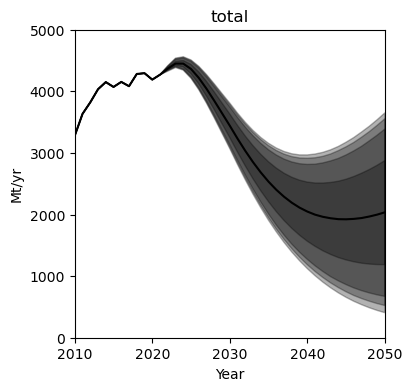

In [7]:
df = pro_percentiles
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    
ax = df[0.5].plot(color='k')
ax.fill_between(df.index, df[0.02], df[0.98], color='k', alpha=0.3)
ax.fill_between(df.index, df[0.05], df[0.95], color='k', alpha=0.3)
ax.fill_between(df.index, df[0.1], df[0.9], color='k', alpha=0.3)
ax.fill_between(df.index, df[0.25], df[0.75], color='k', alpha=0.3)
ax.set_xlim(2010, 2050)
ax.set_ylim(0, 5000)
ax.set_xlabel('Year')
ax.set_ylabel('Mt/yr')
ax.set_title('total')